In [1]:
from sksurv.datasets import load_veterans_lung_cancer


In [3]:
data_x, data_y = load_veterans_lung_cancer()
data_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


In [4]:
from lifelines import KaplanMeierFitter

In [5]:
kmf = KaplanMeierFitter()

In [6]:
T = data_y["Survival_in_days"]
E = data_y["Status"]
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 137 total observations, 9 right-censored observations>

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

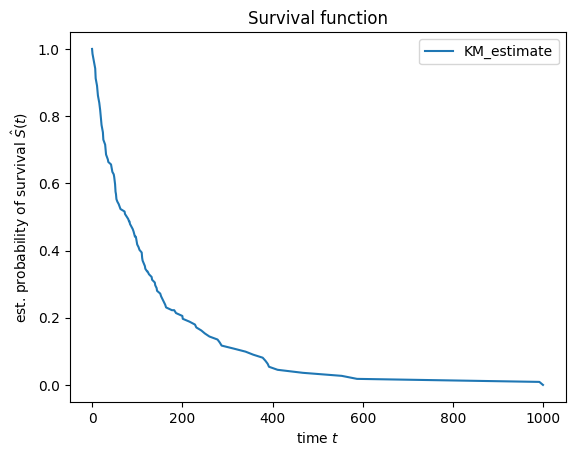

In [10]:
kmf.survival_function_.plot()
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Survival function');

Text(0.5, 0, 'time $t$')

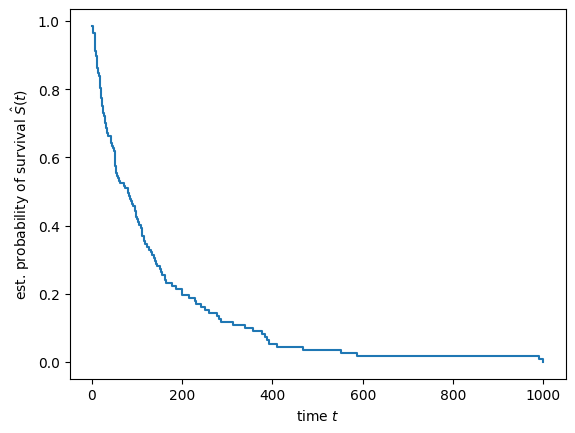

In [9]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Survival_in_days"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

Roughly half the patients received the alternative treatment.
> *Is there any difference in survival between the two treatment groups?*

As a first attempt, we can estimate the survival function in both treatment groups separately.

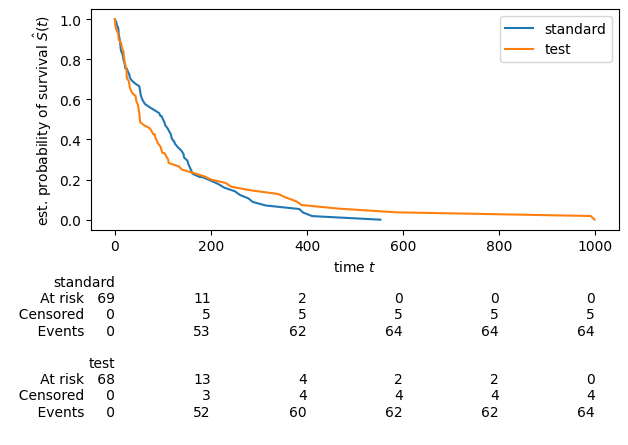

In [20]:
ax = plt.subplot(111)
from lifelines.plotting import add_at_risk_counts
kmfs = []
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    kmf = KaplanMeierFitter()
    kmf.fit(data_y["Survival_in_days"][mask_treat], event_observed= data_y["Status"][mask_treat], label=f"{treatment_type}")
    kmf.survival_function_.plot(ax=ax)
    kmfs.append(kmf)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
#plt.legend(loc="best")
add_at_risk_counts(kmfs[0],kmfs[1], ax=ax)
plt.tight_layout()

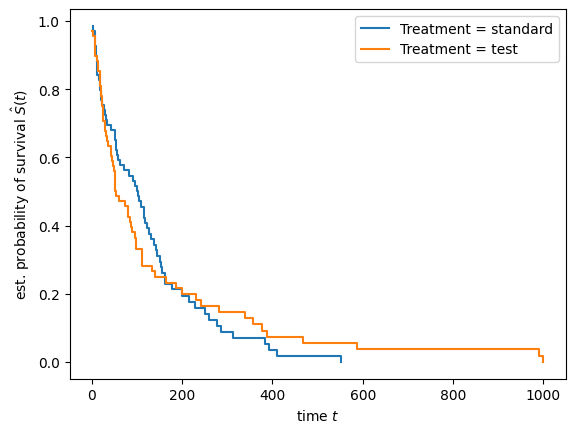

In [13]:
for treatment_type in ("standard", "test"):
    mask_treat = data_x["Treatment"] == treatment_type
    time_treatment, survival_prob_treatment = kaplan_meier_estimator(
        data_y["Status"][mask_treat],
        data_y["Survival_in_days"][mask_treat])
    
    plt.step(time_treatment, survival_prob_treatment, where="post",
             label="Treatment = %s" % treatment_type)

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [21]:
data_x["Treatment"].unique()

['standard', 'test']
Categories (2, object): ['standard', 'test']

In [27]:
from lifelines.statistics import logrank_test
mask_treat = data_x["Treatment"] == "test"
T_exp, E_exp = data_y['Status'][mask_treat], data_y['Survival_in_days'][mask_treat]
mask_treat = data_x["Treatment"] == "standard"
T_con, E_con = data_y['Status'][mask_treat], data_y['Survival_in_days'][mask_treat]
results = logrank_test(T_exp, T_con, event_observed_A=E_exp, event_observed_B=E_con)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.10 0.75      0.42

In [55]:
from lifelines import CoxPHFitter

    
dfA = pd.DataFrame({'E': E_exp, 'T': T_exp, 'groupA': 1})
E2_con = E_con[:-1]
T2_con = T_con[:-1]
dfB = pd.DataFrame({'E': E2_con, 'T': T2_con, 'groupA': 0})
df = pd.concat([dfA, dfB])

cph = CoxPHFitter().fit(df, 'T', 'E')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 136 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 136
number of events observed = 136
   partial log-likelihood = -535.49
         time fit was run = 2022-12-19 15:59:45 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
groupA     -0.02       0.98       0.17            -0.35             0.32                 0.70                 1.38

            cmp to     z    p   -log2(p)
covariate                               
groupA        0.00 -0.09 0.93       0.11
---
Concordance = 0.50
Partial AIC = 1072.99
log-likelihood ratio test = 0.01 on 1 df
-log2(p) of ll-ratio test = 0.11

In [80]:
from sksurv.compare import compare_survival
group_indicator = data_x.loc[:, "Treatment"]
groups = group_indicator.unique()
groups
chisq, pvalue, stats, covar = compare_survival(
        data_y, group_indicator, return_stats=True)
chisq, pvalue, stats, covar

(0.008227343202350305,
 0.9277272333400758,
           counts  observed   expected  statistic
 group                                           
 standard      69        64  64.500197  -0.500197
 test          68        64  63.499803   0.500197,
 array([[ 30.4103884, -30.4103884],
        [-30.4103884,  30.4103884]]))

# Multivariates Analysis

In [56]:
from sksurv.preprocessing import OneHotEncoder

data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

/Users/yvesgreatti/venv/general_39/lib/python3.9/site-packages/sksurv/column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():


,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0


In [57]:
data_x

,Age_in_years,Celltype,Karnofsky_score,Months_from_Diagnosis,Prior_therapy,Treatment
0,69.0,squamous,60.0,7.0,no,standard
1,64.0,squamous,70.0,5.0,yes,standard
2,38.0,squamous,60.0,3.0,no,standard
3,63.0,squamous,60.0,9.0,yes,standard
4,65.0,squamous,70.0,11.0,yes,standard
...,...,...,...,...,...,...
132,65.0,large,75.0,1.0,no,test
133,64.0,large,60.0,5.0,no,test
134,67.0,large,70.0,18.0,yes,test
135,65.0,large,80.0,4.0,no,test


In [58]:
data_x_numeric.shape

(137, 8)

In [66]:
data_yy = pd.concat([pd.Series(data_y['Status']), pd.Series(data_y['Survival_in_days'])], axis=1)

In [72]:
data = pd.concat([data_x_numeric, data_yy], axis=1)
data = data.rename({0:"Status", 1:"Survival_in_days"}, axis=1)
data

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test,Status,Survival_in_days
0,69.0,0.0,0.0,1.0,60.0,7.0,0.0,0.0,True,72.0
1,64.0,0.0,0.0,1.0,70.0,5.0,1.0,0.0,True,411.0
2,38.0,0.0,0.0,1.0,60.0,3.0,0.0,0.0,True,228.0
3,63.0,0.0,0.0,1.0,60.0,9.0,1.0,0.0,True,126.0
4,65.0,0.0,0.0,1.0,70.0,11.0,1.0,0.0,True,118.0
...,...,...,...,...,...,...,...,...,...,...
132,65.0,1.0,0.0,0.0,75.0,1.0,0.0,1.0,True,133.0
133,64.0,1.0,0.0,0.0,60.0,5.0,0.0,1.0,True,111.0
134,67.0,1.0,0.0,0.0,70.0,18.0,1.0,1.0,True,231.0
135,65.0,1.0,0.0,0.0,80.0,4.0,0.0,1.0,True,378.0


In [74]:
cph = CoxPHFitter()
cph.fit(data, duration_col='Survival_in_days', event_col='Status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 137 total observations, 9 right-censored observations>
             duration col = 'Survival_in_days'
                event col = 'Status'
      baseline estimation = breslow
   number of observations = 137
number of events observed = 128
   partial log-likelihood = -474.40
         time fit was run = 2022-12-19 16:35:12 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
Age_in_years           -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
Celltype=large         -0.79       0.45       0.30            -1.39            -0.20                 0.25                 0.82
Celltype=smallcell     -0.33       0.72       0.28            -0.88             0.21                 0.42                 1.23
Celltype=squamous      -1.20       0.30       0.30            -1.79            -0.61                 0.17                 0.55
Karnofsky_score        -0.03       0.97       0.01            -0.04            -0.02                 0.96                 0.98
Months_from_Diagnosis   0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
Prior_therapy=yes       0.07       1.07       0.23            -0.38             0.53                 0.68                 1.69
Treatment=test          0.29       1.34       0.21            -0.11             0.70                 0.89                 2.02

                        cmp to     z      p   -log2(p)
covariate                                             
Age_in_years              0.00 -0.94   0.35       1.52
Celltype=large            0.00 -2.62   0.01       6.85
Celltype=smallcell        0.00 -1.21   0.23       2.15
Celltype=squamous         0.00 -3.97 <0.005      13.79
Karnofsky_score           0.00 -5.96 <0.005      28.55
Months_from_Diagnosis     0.00  0.01   0.99       0.01
Prior_therapy=yes         0.00  0.31   0.76       0.40
Treatment=test            0.00  1.42   0.16       2.68
---
Concordance = 0.74
Partial AIC = 964.79
log-likelihood ratio test = 62.10 on 8 df
-log2(p) of ll-ratio test = 32.37

In [75]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_numeric, data_y)

CoxPHSurvivalAnalysis()

In [76]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

Age_in_years            -0.008549
Celltype=large          -0.788672
Celltype=smallcell      -0.331813
Celltype=squamous       -1.188299
Karnofsky_score         -0.032622
Months_from_Diagnosis   -0.000092
Prior_therapy=yes        0.072327
Treatment=test           0.289936
dtype: float64

# Prediction

In [81]:
x_new = pd.DataFrame.from_dict({
    1: [65, 0, 0, 1, 60, 1, 0, 1],
    2: [65, 0, 0, 1, 60, 1, 0, 0],
    3: [65, 0, 1, 0, 60, 1, 0, 0],
    4: [65, 0, 1, 0, 60, 1, 0, 1]},
     columns=data_x_numeric.columns, orient='index')
x_new

,Age_in_years,Celltype=large,Celltype=smallcell,Celltype=squamous,Karnofsky_score,Months_from_Diagnosis,Prior_therapy=yes,Treatment=test
1,65,0,0,1,60,1,0,1
2,65,0,0,1,60,1,0,0
3,65,0,1,0,60,1,0,0
4,65,0,1,0,60,1,0,1


In [88]:
pred_surv1 = cph.predict_survival_function(x_new)
pred_surv1

,1,2,3,4
1.0,0.994390,0.995818,0.990131,9.867722e-01
2.0,0.991550,0.993700,0.985152,9.801159e-01
3.0,0.988670,0.991549,0.980113,9.733913e-01
4.0,0.985730,0.989352,0.974981,9.665545e-01
7.0,0.976847,0.982703,0.959545,9.460647e-01
...,...,...,...,...
467.0,0.059214,0.121806,0.006854,1.243149e-03
553.0,0.043832,0.097358,0.004033,6.100115e-04
587.0,0.028831,0.071264,0.001927,2.263321e-04
991.0,0.013549,0.040605,0.000509,3.788669e-05


In [103]:
pred_surv1.shape

(101, 4)

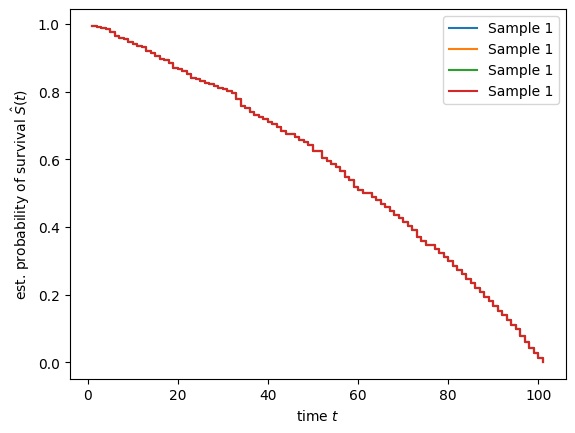

In [105]:
import numpy as np

pred_surv = cph.predict_survival_function(x_new)
time_points = np.arange(1, 102)
for c in pred_surv.columns:
    plt.step(time_points, pred_surv.iloc[:,i], where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

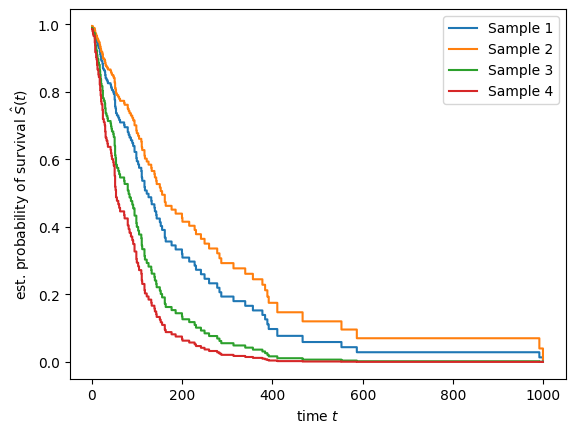

In [106]:
import numpy as np

pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(1, 1000)
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label="Sample %d" % (i + 1))
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

In [107]:
a = np.array([0,0,0])

In [110]:
a[0] += 1

In [111]:
a

array([2, 0, 0])

In [ ]:
a